In [1]:
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
print('CUDA Version: ',torch.version.cuda)
print('CUDA devices (GPU\'s) found: ',torch.cuda.device_count())
assert(torch.cuda.is_available())

CUDA Version:  11.8
CUDA devices (GPU's) found:  1


TODO:

- add more appropriate metrics than just accuracy
- comment code

# Shadow model notebook 

This notebook will load in the target model and attempt to do a model stealing attack on it.

In [2]:
class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(28 * 28, 64)
        self.l2 = nn.Linear(64,64)
        self.l3 = nn.Linear(64, 10)
        # dropout module with 0.1 drop probability
        # helps in preventing overfitting
        self.do = nn.Dropout(0.1)
    
    def forward(self,x):
        h1 = nn.functional.relu(self.l1(x))
        h2 = nn.functional.relu(self.l2(h1))
        do = self.do(h2 + h1)
        logits = self.l3(do)
        # return an array of logits
        return logits
target = ResNet().cuda()
target.load_state_dict(torch.load('target.pth'))

<All keys matched successfully>

### Verify that the model works correctly

In [3]:
data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
# the split here is not needed, but I still want to validate that the model is working, and not run the entire dataset
_, val = random_split(data, [50000, 10000])
val_loader = DataLoader(val, batch_size=32)
loss = nn.CrossEntropyLoss()

In [4]:
losses = []
accuracy = []
for batch in val_loader:
    x, y = batch
    batch_size = x.size(0)
    x = x.view(batch_size, -1).cuda()

    
    with torch.no_grad():
      logit = target(x)
    objective = loss(logit, y.cuda())
    losses.append(objective.item())
    accuracy.append(y.eq(logit.detach().argmax(dim=1).cpu()).float().mean())

print(f'Target loss: {torch.tensor(losses).mean():.2f}')
print(f'Target accuracy: {torch.tensor(accuracy).mean():.2f}')

Target loss: 0.21
Target accuracy: 0.94


### Training the shadow model

In [5]:
train, val = random_split(data, [55000, 5000])
val, test = random_split(val, [4000, 1000])
val_for_target = DataLoader(val, batch_size=32)
train_for_target = DataLoader(train, batch_size=32)
test_loader = DataLoader(test, batch_size=32)

shadow = ResNet().cuda()


optimiser = optim.SGD(shadow.parameters(), lr=1e-2)
loss = nn.CrossEntropyLoss()


In [6]:
def show_image(image, label):
    image_np = image.squeeze().numpy()
    plt.imshow(image_np, cmap='gray')
    plt.title(f"Label: {label.item()}")
    plt.axis('off')
    plt.show()

In [7]:
num_epoch = 5
for epoch in range(num_epoch):
  losses = []

  for batch in train_for_target:
    #we shouldn't use the labels from the data, we should use the target model to generate the labels
    image, t = batch
    
    lables = target(image.cuda().view(image.size(0), -1)).argmax(dim=1)

    batch_size = image.size(0)
    image = image.view(batch_size, -1).cuda()
    logit = shadow(image)
    objective = loss(logit, lables.cuda())
    shadow.zero_grad()
    objective.backward()
    optimiser.step()
    losses.append(objective.item())

  losses = []
  accuracy = []
  for batch in val_for_target:
    x, y = batch
    batch_size = x.size(0)

    x = x.view(batch_size, -1).cuda()
    with torch.no_grad():
      logit = shadow(x)
    objective = loss(logit, y.cuda())
    losses.append(objective.item())
    accuracy.append(y.eq(logit.detach().argmax(dim=1).cpu()).float().mean())

  print(f'Epoch {epoch + 1}, validation loss: {torch.tensor(losses).mean():.2f}')
  print(f'Epoch {epoch + 1}, validation accuracy: {torch.tensor(accuracy).mean():.2f}')

Epoch 1, validation loss: 0.43
Epoch 1, validation accuracy: 0.87
Epoch 2, validation loss: 0.36
Epoch 2, validation accuracy: 0.89
Epoch 3, validation loss: 0.32
Epoch 3, validation accuracy: 0.90
Epoch 4, validation loss: 0.32
Epoch 4, validation accuracy: 0.91
Epoch 5, validation loss: 0.30
Epoch 5, validation accuracy: 0.91


Shadow model accuracy: 0.91
Predicted: 6 Actual: 3


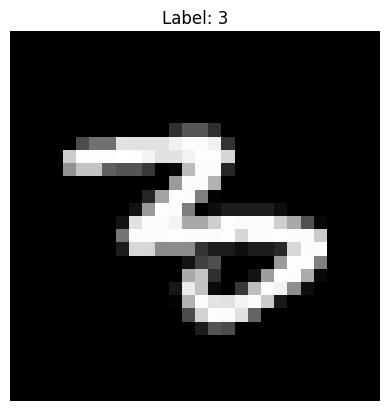

Predicted: 4 Actual: 8


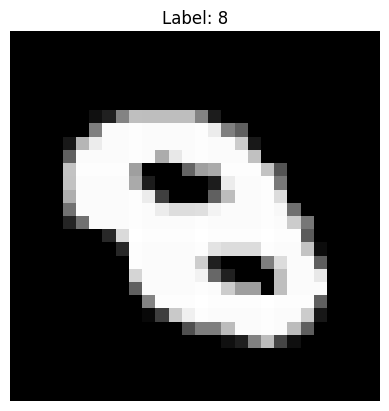

Predicted: 3 Actual: 8


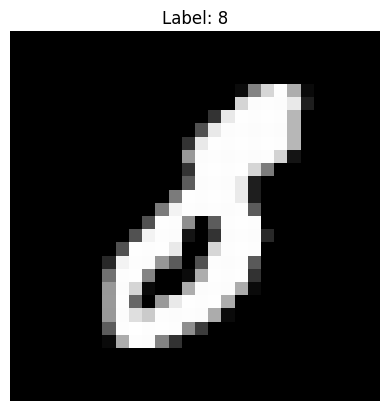

Predicted: 9 Actual: 4


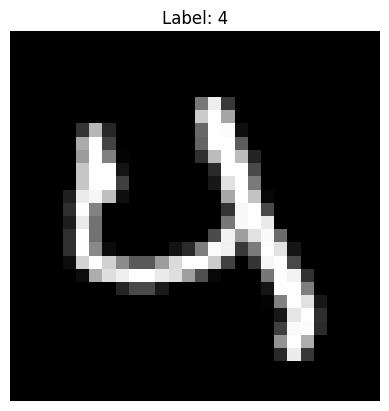

Predicted: 4 Actual: 9


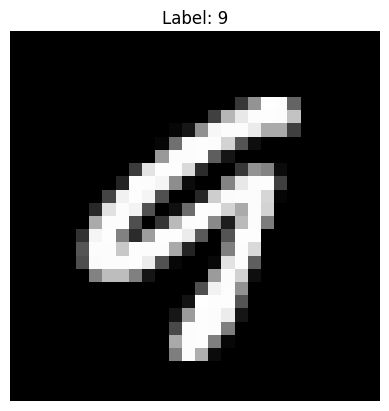

Predicted: 5 Actual: 3


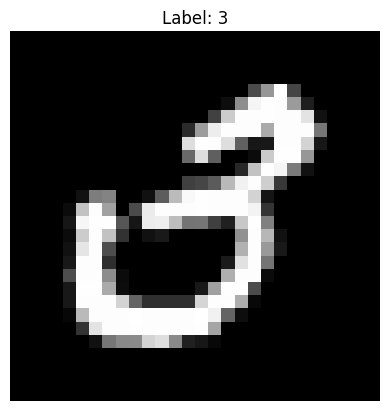

Predicted: 0 Actual: 6


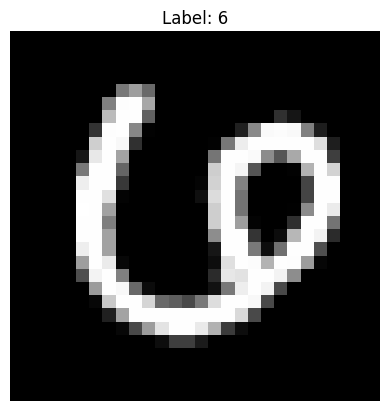

Predicted: 5 Actual: 8


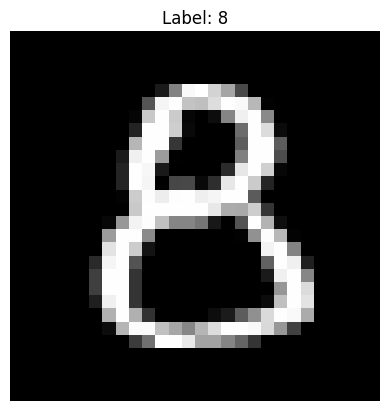

Predicted: 8 Actual: 5


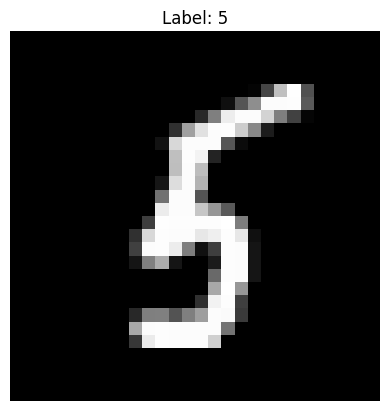

Predicted: 8 Actual: 2


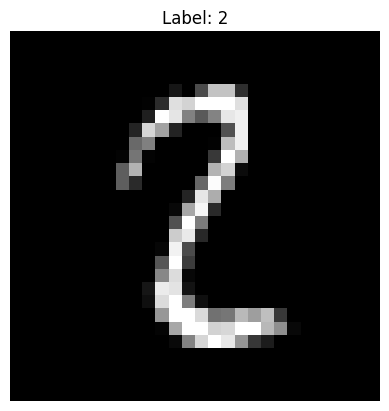

In [8]:

class image_obj:
    def __init__(self, image, label, prediction):
        self.image = image
        self.label = label
        self.prediction = prediction

incorrect_images = []

for batch in test_loader:
    img, y = batch
    batch_size = img.size(0)
    x = img.view(batch_size, -1).cuda()
    with torch.no_grad():
      logit = shadow(x)
    predicted = logit.argmax(dim=1)
    for i in range(32):
        try:
            if predicted[i] != y[i]:
                incorrect_images.append(image_obj(img[i], y[i], predicted[i]))
        except:
            pass

accuracy = 1 - len(incorrect_images) / 1000
print(f"Shadow model accuracy: {accuracy:.2f}")

for i in range(10):
    print(f"Predicted: {incorrect_images[i].prediction.item()} Actual: {incorrect_images[i].label.item()}")
    show_image(incorrect_images[i].image, incorrect_images[i].label)
    



Number of incorrect images: 94


<AxesSubplot: title={'center': 'Incorrect Predictions'}>

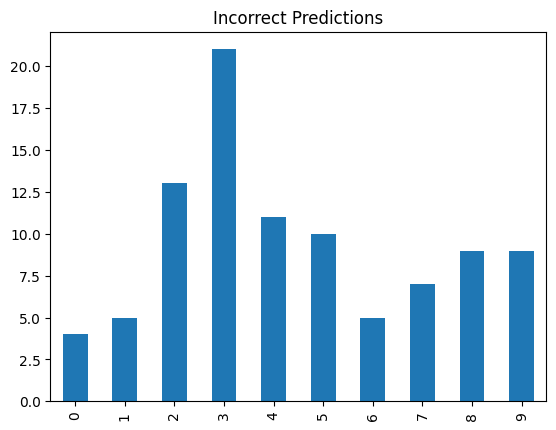

In [9]:
print(f'Number of incorrect images: {len(incorrect_images)}')
df = pd.DataFrame()
df['label'] = [x.label.item() for x in incorrect_images]
df['prediction'] = [x.prediction.item() for x in incorrect_images]
df['image'] = [x.image for x in incorrect_images]


incorrect_counts = df['label'][df['label'] != df['prediction']].value_counts()
incorrect_counts = incorrect_counts.sort_index()
incorrect_counts.plot(kind='bar', title='Incorrect Predictions')